[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/IPML/blob/master/tutorial_notebooks/6_USL_for_clustering_solutions.ipynb)

# Unsupervised Learning Using Clustering

<span style="color:red; font-weight: bold;"> This notebook includes solutions to all programming tasks.</span>

<hr>
<br>

This notebook revisits the lecture on **Unsupervised Machine Learning using Clustering**. There, we studied business applications of cluster analysis and familiarized ourself with the famous kMeans algorithm. This notebook comprises a set of demos and programming exercises to illustrate the corresponding concepts and exemplify relevant procedures.

Key topics:
- Synthetic data generation
    - The `make_blobs`function 
    - The multivariate normal distribution
- Visualizing 2D data using scatterplots
- The kMeans algorithm
    - Executing kMeans using `sklearn`
    - The elbow method for determining the number of clusters

In [1]:
# Load standard libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

# Creating synthetic data for clustering

## Sampling from Gaussian distribution 
We use the function `make_blobs()` from the `sklearn.datasets` module to create synthetic data in 2D for clustering. You can set the number of clusters via the argument `centers`. Also, you can configure the function such that it returns the locations of the cluster centers. This will be useful for later comparisons. Thus, make use of this feature by setting `return_centers=True`.

### Exercise 1: 
- Import the `make_blobs()` function
- Familiarize yourself with its documentation
- Use the function to generate 50 data points and store the results in a suitable data type
- Visualize your synthetic data by means of a scatter plot.

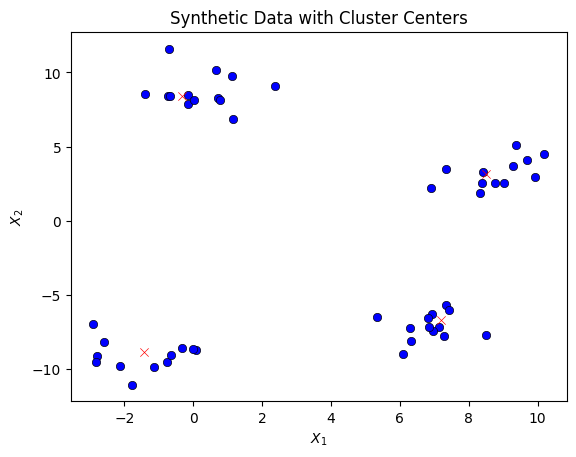

In [2]:
# Solution to exercise 1 
# Import the make_blobs() function
from sklearn.datasets import make_blobs

# Generate 50 data points and store the results in a suitable data type
X, y, centers = make_blobs(n_samples=50, n_features=2, centers=4, return_centers=True, random_state=888)

# Visualize the synthetic data by means of a scatter plot
sns.scatterplot(x=X[:, 0], y=X[:, 1], c='blue', marker='o', edgecolor='k')
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], c='red', marker='x')  # Plot the centers
plt.title('Synthetic Data with Cluster Centers')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()

### The multivariate normal distribution
For better understanding of the `make_blobs()` function, the following code creates a 2D surface plot of the bi-variate normal distribution. First, we define a multivariate normal distribution with a mean of `mu=[0.0, 0.0]` and a covariance matrix 
```Python
sigma = [[1.0, 0.0],[0.0, 1.0]]
```
Next, we create a grid of points at which we evaluate the density using the function `meshgrid()`. Last, we visualize the results using a *surface plot*. 

 You can adjust the mean and covariance matrix to change the shape of the distribution. The `linspace` function is used to create the grid of points, and the `dstack` function is used to combine the x and y coordinates into a single array. The `multivariate_normal` function is used to create the distribution, and the `pdf` method is used to evaluate the distribution at the grid points. The `plot_surface` function is used to create the surface plot. 
 
 Please make sure you have the `scipy` library installed in your Python environment. If needed, you can install it using pip:

```bash
pip install scipy
```

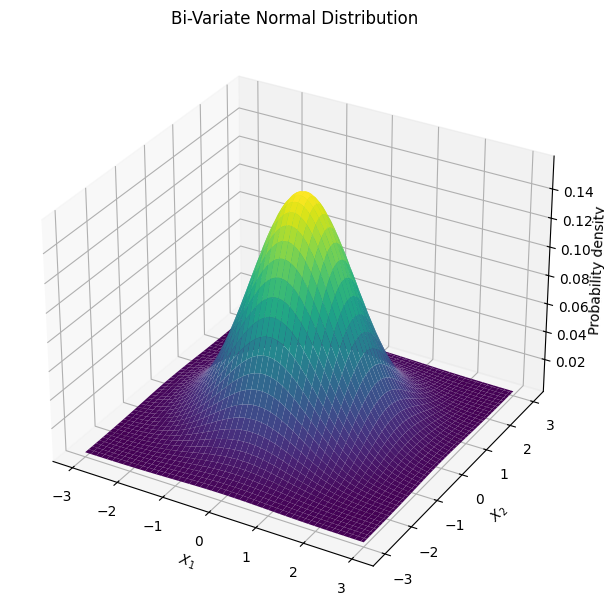

In [3]:
from scipy.stats import multivariate_normal

# Define the mean and covariance matrix for the distribution
mu = np.array([0.0, 0.0])
cov = np.array([[1.0, 0.0], [0.0, 1.0]])

# Create a grid of points at which to evaluate the distribution
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
pos = np.dstack((X1, X2))

# Create the multivariate normal distribution and evaluate it at the grid points
rv = multivariate_normal(mu, cov)
Z = rv.pdf(pos)

# Create the surface plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap='viridis')
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.set_zlabel('Probability density', labelpad=1)
plt.tight_layout()
plt.title('Bi-Variate Normal Distribution')
plt.show()

Intuitively, when using the `make_blobs()` function, the `centers` argument corresponds to the mean of the multivariate normal distribution, and the `cluster_std` argument corresponds to the standard deviation of the distribution. Hence, each cluster is associated with one multivariate (i.e., bi-variate in our case) normal distribution. For each cluster, the function samples the points from the corresponding multivariate normal distribution with the specified mean and standard deviation. 

## Exercise 2:
Redo the previous exercise, but this time, create a synthetic data set with only two clusters. To that end:
- Introduce a variable `mu` to store the cluster centers. Set the centers to be `(2, 2)` and `(4, 4)`.
- Introduce a variable `std` (standard deviation) and set it to 0.5.
- Generate 100 data points with the specified cluster centers and standard deviation using `make_blobs()`.
    - Store the data points in a variable `X`.
    - Store the true cluster index of each data point in a variable `y`.
    - Store the cluster centers in a variable `centers`.
- Visualize the synthetic data points and the cluster centers by reusing your solution to exercise 1.
- Make sure that data points from different clusters receive different colors. To achieve this, you can set the argument `c` of the `scatterplot` function to the cluster index, which `make_blobs()` returns.

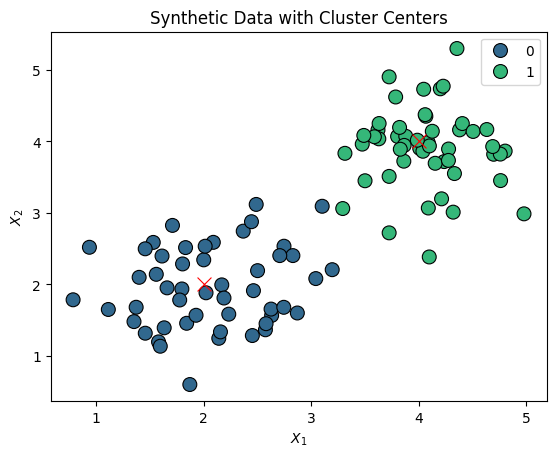

In [4]:
# Solution to exercise 2

mu = np.array([[2.0, 2.0], [4, 4]])
std = 0.5

# Generate 100 data points and store the results in a suitable data type
X, y, centers = make_blobs(n_samples=100, n_features=2, centers=mu, cluster_std=std, return_centers=True, random_state=123)

# Visualize the synthetic data by means of a scatter plot
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='viridis', edgecolor='k', s=100)
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], c='red', marker='x', s=100)  # Plot the centers
plt.title('Synthetic Data with Cluster Centers')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.show()


# kMeans Clustering 
The following code, which is copied from the [sklearn documentation of `KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans), exemplifies how you can perform kMeans-based clustering. It illustrates the use of the `fit()` functions to execute the algorithm, how you can query the cluster to which the data points were assigned using the `.labels_` property, how you can cluster novel data points using the `predict()` function, and how you can access the found cluster centers using the `cluster_centers_` attribute, as well as the value of the kMeans objective, which is accessible via the `ìnertia_` property.

In [5]:
from sklearn.cluster import KMeans

# Create artificial data
demo = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])  

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(demo)  # run the cluster algorithm
print(kmeans.labels_)  # print the assignment of data points to clusters
print(kmeans.predict([[0, 0], [12, 3]]))  # find the cluster of a novel data point
print(kmeans.cluster_centers_)  # print the location of the cluster centroids
print(kmeans.inertia_)  # print value of the objective function

[1 1 1 0 0 0]
[1 0]
[[10.  2.]
 [ 1.  2.]]
16.0


### Exercise 3:
- Drawing on the kMeans demo, run kMeans on your synthetic data created in exercise 2. 
- Set the number of clusters to *a suitable value*.
- Print the cluster centers and the value of the kMeans objective.
- Also print out the true cluster centers and compare them to those found by kMeans. What is your conclusions?


In [6]:
# Solution to exercise 3

# Execute the kMeans algorithm on the synthetic data 
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)

# Print objective and cluster centers
print(f"kMeans objective: {kmeans.inertia_:.2f}")
print("Found centers:")
print(kmeans.cluster_centers_)

# Compare kMeans cluster centers to true cluster centers
print(f"True centers:\n {centers}")


kMeans objective: 53.65
Found centers:
[[4.05116734 3.89431463]
 [2.03946767 1.94337101]]
True centers:
 [[2. 2.]
 [4. 4.]]


Provided you solved exercise 3, you can run the following codes to visualize the results of the clustering. More specifically, the code visualizes the synthetic data points, whereby the color of a data point indicates its true true cluster membership and the symbol indicates to which cluster it has been assigned by kMeans. If a data point was assigned the *wrong* cluster, the code will highlight this data point with a thick, red border. Further, the code visualizes tje true cluster centers (red crosses) and the cluster centers found by kMeans (yellow diamonds).

For the code to work properly, you need to:
- have a trained kMeans model stored in the variable `kmeans`
- have the true cluster centers stored in the variable `centers`
- have the synthetic data points stored in the variable `X`
- have the true cluster index of each data point stored in the variable `y` 

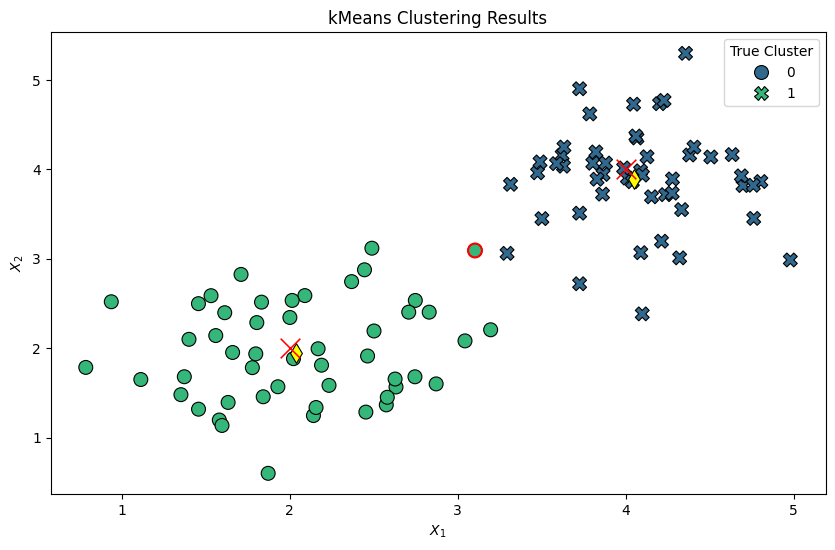

In [7]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

# Create a scatter plot to visualize the clustering results
plt.figure(figsize=(10, 6))

# Synchronize cluster indices between y and kmeans.labels_

# Compute the cost matrix
cost_matrix = pairwise_distances(centers, kmeans.cluster_centers_)
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Create a mapping from true cluster indices to kmeans cluster indices
cluster_mapping = {row: col for row, col in zip(row_ind, col_ind)}

# Map the true cluster indices to kmeans cluster indices
mapped_labels = np.array([cluster_mapping[label] for label in y])

# Plot the true clusters with different colors
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=mapped_labels, palette='viridis', style=y, edgecolor='k', s=100)

# Highlight the misclassified points with red border color
misclassified = (mapped_labels != kmeans.labels_)
sns.scatterplot(x=X[misclassified, 0], y=X[misclassified, 1], facecolor='none', edgecolor='red', s=100, linewidth=1.5)

# Plot cluster centers and centroids

sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], c='yellow', marker='d', edgecolor='k', s=100)  # kMeans centroids
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], c='red', marker='x', s=200)  # Plot the true centers


plt.title('kMeans Clustering Results')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.legend(title='True Cluster')
plt.show()


>**Remark:** The slightly complicated part of the above code concerns the highlighting of data points that kMeans misclassifies. The reason is that the index of a data points's true cluster is not necessarily the same as the index of the cluster to which kMeans assigns the data point. Consequently, a simple comparison `kmeans.labels_ == y` is insufficient to identify misclassified data points. Below, we address this issue by synchronizing the indices before highlighting misclassified data points.  

## Elbow method to determine K

The lecture introduced you to the elbow method. Recall that the elbow method is a heuristic to determine the number of clusters, which, in reality, we would not know.

<img src="https://raw.githubusercontent.com/Humboldt-WI/demopy/main/kmeans_elbow_method.png" width="1280" height="720" alt="kMeans Algorithm">

To apply this method, we can make use of the `.inertia_` attribute of a fitted `KMeans` object. 

### Exercise 4
- Create a list that stores candidate values for the meta-parameter *k* (i.e., number of clusters)
    - Considers settings $k=1, 2, ..., 10$
- Iterate over your list and run *kMeans* for each candidate setting of *k*. 
- Store, from each run of *kMeans, the value of the objective function, that is the property `kmeans.inertia_`
- Create a line plot of *kMeans*´objective values against the corresponding number of cluster (i.e., associated candidate settings of *k*)

Once you created a similar plot for the synthetic data, go back to the `make_blobs()` method and adjust its arguments to examine different types of data and their clustering. For example, examine how the elbow plot changes if you create data with three cluster centers, and examine how it changes if you create overlapping clusters. To achieve this, you can use the argument `cluster_std`, which the function provides.  

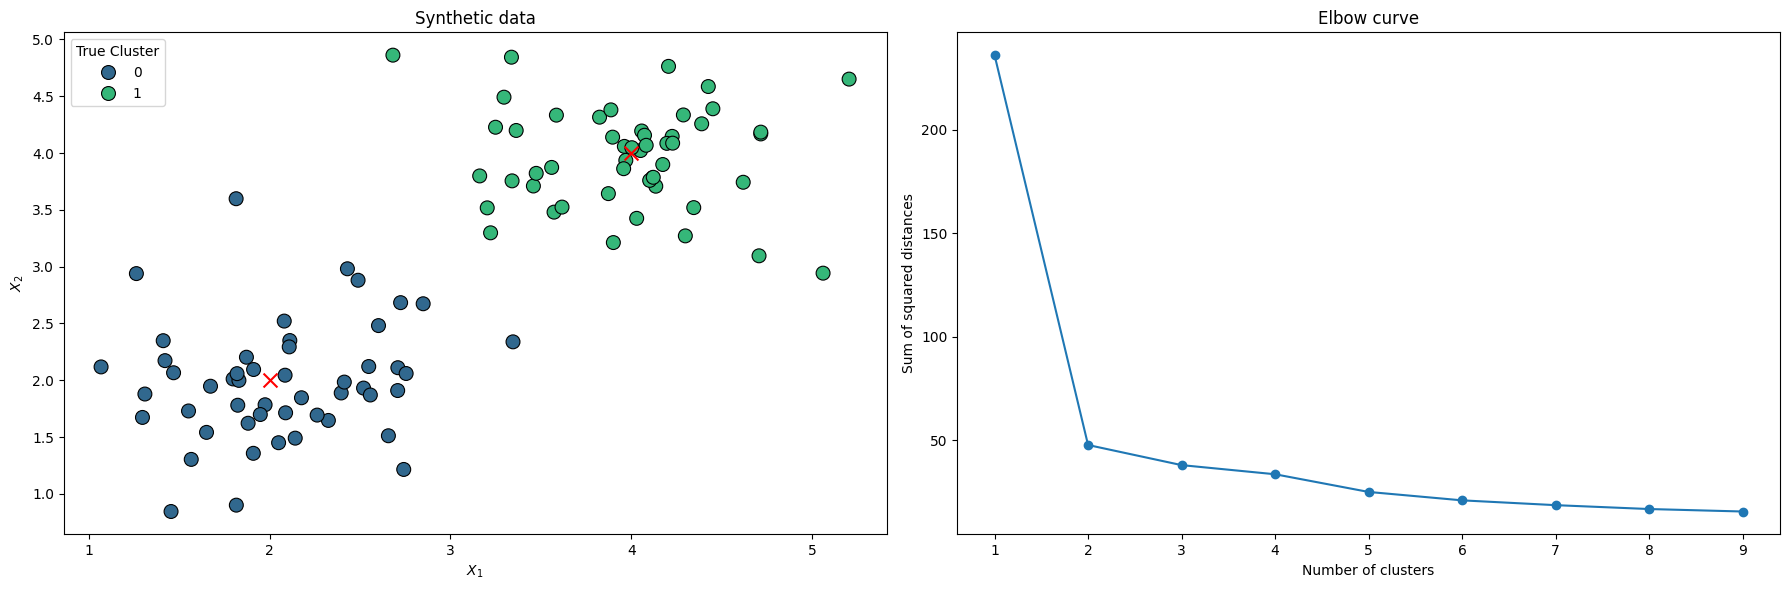

In [8]:
# Solution to exercise 4

# Determine the number of clusters using the elbow method
k_candidates = range(1,10)  # candidate settings of k
objective_values  = []  # empty list to store objective values

# To simplify trying out different data sets, we copy/paste the code to create the data from above
mu = np.array([[2.0, 2.0], [4, 4]])
std = 0.5
X, y, centers = make_blobs(n_samples=100, n_features=2, centers=mu, cluster_std=std, return_centers=True, random_state=888)

for i in k_candidates:
    kmeans = KMeans(n_clusters=i, random_state=888, n_init="auto").fit(X)
    objective_values.append(kmeans.inertia_)

# Create a subplot with two plots next to each other
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Scatter plot to visualize the data
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='viridis', edgecolor='k', s=100, ax=axes[0])
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], c='red', marker='x', s=100, linewidth=1.5, ax=axes[0]) 
axes[0].set_title('Synthetic data')
axes[0].set_xlabel('$X_1$')
axes[0].set_ylabel('$X_2$')
axes[0].legend(title='True Cluster')

# Right plot: Elbow curve
axes[1].plot(k_candidates, objective_values, marker='o')
axes[1].set_title('Elbow curve')
axes[1].set_xlabel('Number of clusters')
axes[1].set_ylabel('Sum of squared distances')

plt.tight_layout()
plt.show()